In [1]:
import vmo 
import vmo.analysis as van
import vmo.analysis.segmentation as vse
import csv
import numpy as np
np.set_printoptions(threshold='nan')

from collections import Counter

import math
import entropy
import matplotlib as mpl 

import matplotlib.pyplot as plt

import matplotlib.cm as cm
from matplotlib import patches
import plotly.plotly as py


import librosa

from nolds import lyap_e, lyap_r, corr_dim

import scipy as sc
import scipy.sparse as sp
from scipy.sparse import spdiags
import scipy.stats


import pylab 
import scipy.weave
import scipy.io.wavfile as wav

import operator

from pyunicorn.timeseries import RecurrencePlot, RecurrenceNetwork

#from python_speech_features import mfcc
#from python_speech_features import logfbank

from pylab import * # show, scatter, xlim, ylim
from random import randint
from random import randrange

import warnings
warnings.filterwarnings('ignore')
warnings.catch_warnings()

#%matplotlib inline
#%pylab inline

pyunicorn: Package netCDF4 could not be loaded. Some functionality in class Data might not be available!
pyunicorn: Package netCDF4 could not be loaded. Some functionality in class NetCDFDictionary might not be available!
Populating the interactive namespace from numpy and matplotlib


In [2]:
# time series standard embedding 
def timeseries_embedding(series=[], m=3, time_delay=1):    
    m = int(m) # m = embedding dimension = nb of columns in the embedded time series matrix
    time_delay = int(time_delay)
    
    n = len(series) 
    
    nb_vectors = n - (m-1) * time_delay # nb of vectors in the embedded time series matrix
    embedded = np.empty((nb_vectors, m), dtype="float32") # embedded series has nb_vectors rows and m columns

    #print embedded.shape
    for j in range(0, m):
        idx = j * time_delay
        
        for k in range(0,nb_vectors):
            embedded[k,j] = series[idx]
            idx += 1
    return embedded

In [3]:
def VMO_GEN(embedded_timeseries, r_threshold, dim = 3):
    threshold = vmo.find_threshold(embedded_timeseries, r = r_threshold, dim = dim)
    
    #print threshold[0][1]
    
    ideal_t = threshold[0][1]
    x_t = [i[1] for i in threshold[1]]
    y_t = [i[0] for i in threshold[1]]
    
    ir = threshold[0][0]

    plt.figure(figsize=(12,2))
    plt.plot(x_t, y_t, linewidth = 2)
    plt.hold('on')
    plt.vlines(ideal_t, 0.0, max(y_t), colors = 'k',linestyle = 'dashed',linewidth = 2)
    plt.grid('on')
    plt.legend(['IR values', 'Selected threshold'], loc=1)
    plt.title('Threshold value versus Information Rate', fontsize = 18)
    plt.xlabel('Threshold Value',fontsize = 14)
    plt.ylabel('Summed IR', fontsize = 14)
    plt.tight_layout()
    
    
    ts_vmo = vmo.build_oracle(embedded_timeseries, flag='a', threshold=ideal_t, dim=dim)

    methods = ['sfx', 'lrs', 'rsfx']

    plt.figure(figsize = (12,4))
    for i,m in enumerate(methods):
        recurrence_vmo = van.create_selfsim(ts_vmo, method=m)
        
        plt.subplot(1,3,i+1)
        plt.imshow(recurrence_vmo, interpolation='nearest', aspect='auto', cmap='Greys')
    
        plt.title(m, fontsize=14)
        plt.tight_layout()
    
    
    return [ts_vmo, threshold[0][1], ir]
    

In [4]:
def Recurrence_VMO(TS_VMO):
    recurrence_vmo = van.create_selfsim(TS_VMO, method='lrs')
    
    return recurrence_vmo

    #plt.figure(figsize = (6,4))
    #plt.imshow(recurrence_vmo, interpolation='nearest', aspect='auto', cmap='Blues')
    #plt.title('lrs', fontsize=14)

In [5]:
def Recurrence_Rate(recurrence_vmo):
    ln= len(recurrence_vmo)
    RR = (np.sum(recurrence_vmo))/float(ln*ln)    
    return RR

In [6]:
# CORRELATION SUM i.e. estimates the CORRELATION DIMENSION D2
def Correlation_Sum(recurrence_vmo):
    ln = len(recurrence_vmo)
    C = (np.sum(recurrence_vmo) - np.sum(recurrence_vmo.diagonal()))/float(ln*ln)
    return C
 

In [7]:
# CORRELATION ENTROPY (2nd order Rényi entropy)
def Correlation_Entropy(recurrence_vmo):
    C = Correlation_Sum(recurrence_vmo)
    K2 = -log(C)
    return K2

In [8]:
def Determinism(recurrence_vmo, diagonal_sum):    
    nume = diagonal_sum #np.sum(L)
    denom = np.sum(recurrence_vmo)
    if (denom > 0):
        DET =  nume / denom        
    else: 
        DET = 'NA'
        
    return DET

In [9]:
def Laminarity(recurrence_vmo, vsum):
    if (np.sum(recurrence_vmo) != 0):
        LAM = vsum / np.sum(recurrence_vmo)        
    else:
        LAM = 'NA'
        
    return LAM


In [10]:
def Divergence(lmax):
    if (lmax > 0):
        DIV = np.divide(1,lmax) 
    else:
        DIV = 'NA'
        
    return DIV
    

In [11]:
def Diagonals(recurrence_vmo):
    # DIAGONALS
    LOI = 0
    newd = {}
    mat = np.zeros((recurrence_vmo.shape[0]*2+1,recurrence_vmo.shape[1]))

    for ii in range(-len(recurrence_vmo), len(recurrence_vmo)):    
        newd[ii]= np.diagonal(recurrence_vmo, offset = ii) 


    for rw in range (0, len(recurrence_vmo)): 
        for cl in range (0, len(recurrence_vmo)):
            if(rw == cl):
                if (recurrence_vmo[rw][cl] == 1):
                    LOI += 1
        
    for i in range (-len(recurrence_vmo), len(recurrence_vmo)):   
        for j in range(len(newd[i])):
            mat[i+len(recurrence_vmo),j] = newd[i][j] 

    diag_idx = 0

    diagonals = np.zeros(recurrence_vmo.size)
    for drow in range(0, len(mat)):    
        diag_sum = 0
        for dcol in range(0, mat.shape[1]):       
            if (mat[drow,dcol] == 1):
                diag_sum += 1           
            if (mat[drow,dcol] == 0):
                if (diag_sum > 0):
                    diagonals[diag_idx] = diag_sum
                    diag_idx += 1
                    diag_sum = 0
        if (diag_sum > 0):
            diagonals[diag_idx] = diag_sum;
            diag_idx += 1
        
        
    dia_cnt = 0
    dia_sum = 0
    for indx in range(0, len(diagonals)):
        if (diagonals[indx] >= 2):
            dia_sum += diagonals[indx]
            dia_cnt += 1

    if (dia_cnt > 0):
        av_diag = dia_sum / dia_cnt        
    else: 
        av_diag = 'NA'    

        
        
    # Longest Diagonal Length without the Line of Identity (LOI):
    newdiag = np.copy(diagonals) # copy array into array newdiag

    max_idx= np.argmax(newdiag)  # get the index of the longest diagonal (could be LOI)

    newdiag[max_idx] = -1 # remove the index of LOI
    L_max = newdiag.max()  # get the second longest diagonal
    
    return [dia_sum, L_max, diagonals, av_diag]

In [12]:
def Verticals(recurrence_vmo):
    
    #find vertical lines
    idx = 0
    vertical = np.zeros(recurrence_vmo.size)
    for c in range(0, recurrence_vmo.shape[1]):       
        s = 0
        for r in range(0, len(recurrence_vmo)):
            if (recurrence_vmo[r,c] == 1):
                s += 1           

            if (recurrence_vmo[r,c] == 0):
                if (s > 0):
                    vertical[idx] = s
                    idx += 1
                    s = 0
        if (s > 0):
            vertical[idx] = s;
            idx += 1


    vcnt = 0
    vsum = 0
    for V in range(0, len(vertical)):
        if (vertical[V] >= 2):
            vsum += vertical[V]
            vcnt += 1

    #----------------------------------------------------------------------------------------------------------   
    # Longest Vertical Line
    V_max = vertical.max()
    
    #----------------------------------------------------------------------------------------------------------   
    # TRAPPING TIME
    if (vcnt > 0):
        TT = vsum /vcnt        
    else: 
        TT = 'NA'   
    
    return [vsum, V_max, vertical, TT]
    


In [13]:
song_path = '/Users/admin/Documents/vmo-master/SILENCETRIMMED/45_happiness.mir.wav'
sr = 44100
hop_length = 512

tseries, sr = librosa.load(song_path, sr=sr)


In [35]:
# compute the Lyapunov Exponent from the time series using Rosenstein's method.
from nolds import lyap_r, lyap_e
dim = 7 # by method of false-nearest neighbour
tau = 11 # by method of first minimum mutual information
LE = lyap_r(tseries, emb_dim=dim,tau=tau)



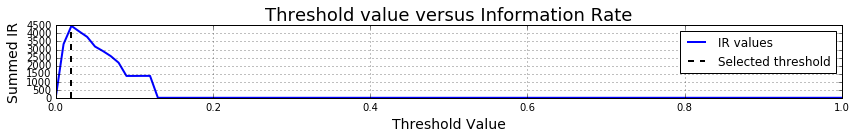

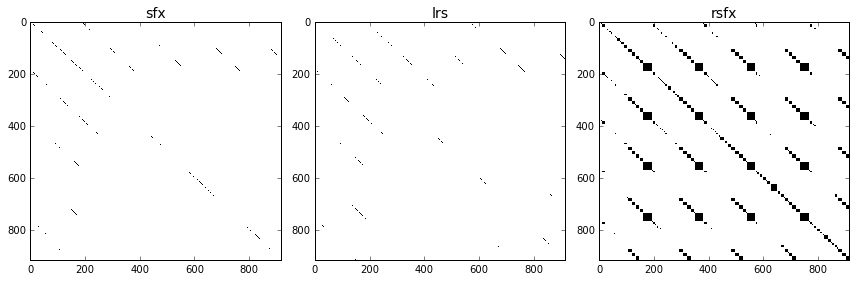

In [33]:
from scipy.stats import entropy

r_threshold = (0, 1.01, 0.01)
    
tseries_embed = timeseries_embedding(tseries, dim, tau) # embed the timeseries
    
# Generate the VMO. Return the VMO (ts_vmo), the ideal threshold (eps) and the optimal information rate (IR)
ts_vmo, eps, ir  = VMO_GEN(tseries_embed, r_threshold, dim) # get the VMO

IR = ir # optimal information rate from the VMO
recurrence_vmo = Recurrence_VMO(ts_vmo)  # get the VMO self-similarity matrix  

In [37]:
diag_stats = Diagonals(recurrence_vmo)  #returns [dia_sum, L_max, diagonals, av_diag]
diagonals = diag_stats[2]

K2 = Correlation_Entropy(recurrence_vmo) # approximates the Kolmogorov-Sinai entropy from the VMO recurrence plot
D2 = Correlation_Sum(recurrence_vmo)
print "D2: ", D2

# Get hist = probability distribution of diagonal line lengths
hist = np.bincount(int64(diagonals)) # Histogram of diagonals (probability distribution of diagonals of length l)   
hist = hist[1:len(hist)]

entropie = entropy(hist, base=2)      
KS = entropie - ir # Kolmogorov-Sinai entropy estimate from the VMO-Information Rate

#corrdim = corr_dim(tseries, emb_dim=dim)
corrdim = corr_dim(test, emb_dim=dim)
print "corrdim: ", corrdim

#det = Determinism(recurrence_vmo, diag_stats[0])
#div = Divergence(diag_stats[1])
#rr = Recurrence_Rate(recurrence_vmo)
#vert_stats = Verticals(recurrence_vmo) # returns [vsum, V_max, vertical, TT]
##lam = Laminarity(recurrence_vmo, vert_stats[0])

D2:  0.00120135008867
corrdim:  1.57416011716


In [54]:
#import csv
#Assuming complexity_measures is a flat list
#with open('COMPLEXITYMEASURES_MAV.csv', 'a') as csvfile:
#    fieldnames=['Sound', 'LE', 'KS', 'K2', 'D2', 'IR']
#    writer = csv.DictWriter(csvfile, delimiter=',', fieldnames=fieldnames)
#    writer.writerow({'Sound': '45_Happiness', 'LE': LE, 'KS': KS,'K2': K2, 'D2': D2, 'IR': IR})
  